# Training Mars Landmark Identifier Model with Convolutional Neural Network

Best Model(s):
- 20200221-060223.h5
- 20200221-060730.h5

### Python 2/3 Compatibility Import

In [1]:
### Python 2/3 Compatibility Import
from __future__ import absolute_import, division, print_function, unicode_literals

### Imports

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

# Helper libraries
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os # for parallelization
import pathlib

#### Pre-processing Functions

In [3]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

In [4]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # convert to grayscale
    img = tf.image.rgb_to_grayscale(img)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [5]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#### Declarations

In [6]:
# Paths
training_path = pathlib.Path("hirise-map-proj-v3/training/")
testing_path = pathlib.Path("hirise-map-proj-v3/testing/")

# Mars Landmark Classes
CLASS_NAMES = np.array([item.name for item in testing_path.glob("*")])

# Image Size
IMG_WIDTH = IMG_HEIGHT = 128
BATCH_SIZE = 32

#### Loading

In [48]:
train_files = tf.data.Dataset.list_files(str("hirise-map-proj-v3/training/*/*"))
train_ds = train_files.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
test_files = tf.data.Dataset.list_files(str("hirise-map-proj-v3/testing/*/*"))
test_ds = test_files.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [9]:
# Check Data
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Image: ", image.numpy())
    print("Label: ", label.numpy())

Image shape:  (128, 128, 1)
Image:  [[[0.45342705]
  [0.44529942]
  [0.43565527]
  ...
  [0.4666667 ]
  [0.47123387]
  [0.4784314 ]]

 [[0.4660211 ]
  [0.4548014 ]
  [0.44402575]
  ...
  [0.47084868]
  [0.47398236]
  [0.47780335]]

 [[0.46917242]
  [0.4614473 ]
  [0.45098042]
  ...
  [0.46718752]
  [0.47062996]
  [0.47084868]]

 ...

 [[0.5978554 ]
  [0.5996324 ]
  [0.59609574]
  ...
  [0.58873886]
  [0.59200794]
  [0.59633887]]

 [[0.60428256]
  [0.603821  ]
  [0.59655756]
  ...
  [0.59559935]
  [0.5926844 ]
  [0.5987264 ]]

 [[0.60780156]
  [0.6059414 ]
  [0.60026044]
  ...
  [0.6082108 ]
  [0.59557515]
  [0.60388   ]]]
Label:  [False False False False  True False False False]


#### Batching

In [10]:
# Create batches and store batches into cache
def prepare_for_training(ds, cache=True, shuffle_buffer_size=10000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
    else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

In [11]:
# Let's peek at our batch
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(8,4,n+1)
        plt.imshow(image_batch[n],cmap="gray")
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

In [49]:
# Let's prep our training set
X_train = prepare_for_training(train_ds)

image_batch, label_batch = next(iter(X_train))

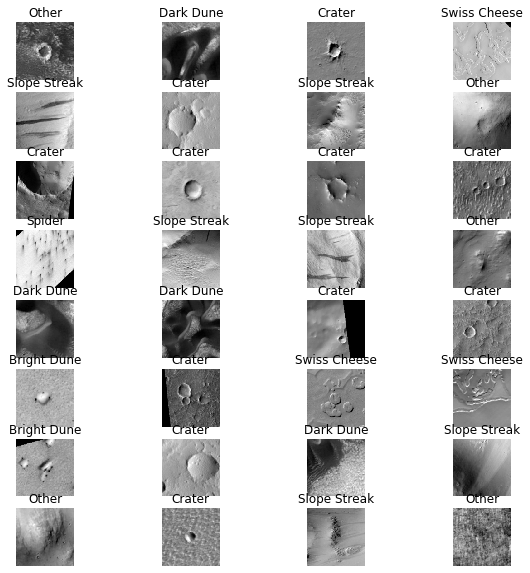

In [43]:
# Preview batch
show_batch(image_batch[:,:,:,0].numpy(), label_batch.numpy())

### Modeling

In [ ]:
# CNN Model
model = Sequential(name="MLI_CNN")
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(8, activation="softmax"))

model.summary()

### Compile & Train

In [66]:
# Compile model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)

# Logs for Tensorboard
if os.name == "nt":
    log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
else:
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [65]:
# Load previous weights if needed and recompile
model = tf.keras.models.load_model('models/20200221-060223.h5')

In [ ]:
# Fitting
MLI_FIT = model.fit(X_train,
                    epochs=10,
                    steps_per_epoch=100,
                    callbacks=[tensorboard_callback],
                    validation_data=prepare_for_training(test_ds),
                    validation_steps=10
                    )
# Save Model
if os.name == "nt":
    model.save("models\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".h5")
else:
    model.save("models/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".h5")

### Evaluate

In [67]:
test_loss, test_acc = model.evaluate(prepare_for_training(test_ds), steps=10, verbose=2)

10/10 - 0s - loss: 2.4254 - categorical_accuracy: 0.7375


### Prediction

In [17]:
def predict_format(arr):
    if arr[0] == 1:
        return CLASS_NAMES[0]
    elif arr[1] == 1:
        return CLASS_NAMES[1]
    elif arr[2] == 1:
        return CLASS_NAMES[2]
    elif arr[3] == 1:
        return CLASS_NAMES[3]
    elif arr[4] == 1:
        return CLASS_NAMES[4]
    elif arr[5] == 1:
        return CLASS_NAMES[5]
    elif arr[6] == 1:
        return CLASS_NAMES[6]
    elif arr[7] == 1:
        return CLASS_NAMES[7]

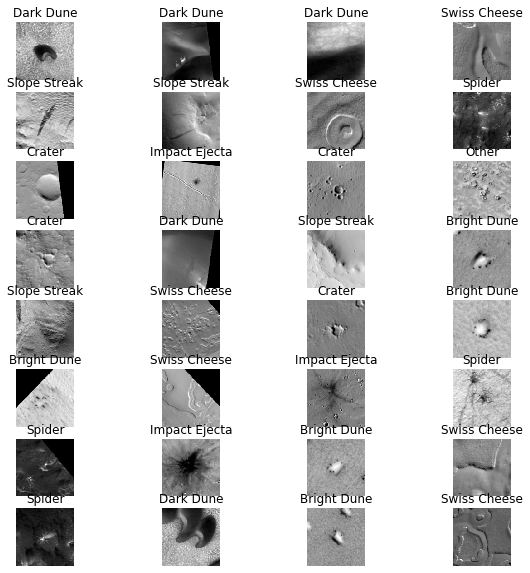

In [70]:
predict = prepare_for_training(test_ds)

prd_img, prd_lbl = next(iter(predict))

show_batch(prd_img[:,:,:,0].numpy(), prd_lbl.numpy())

In [71]:
prediction = [predict_format(i) for i in model.predict(prd_img.numpy(),steps=1).round()]
prediction

['dark dune',
 'dark dune',
 'dark dune',
 'slope streak',
 'slope streak',
 'slope streak',
 'swiss cheese',
 'dark dune',
 'crater',
 'crater',
 'crater',
 'crater',
 'crater',
 'dark dune',
 'slope streak',
 'bright dune',
 'slope streak',
 'swiss cheese',
 'crater',
 'bright dune',
 'bright dune',
 'swiss cheese',
 'other',
 'other',
 'spider',
 'slope streak',
 'bright dune',
 'swiss cheese',
 'spider',
 'dark dune',
 'bright dune',
 'swiss cheese']

In [ ]:
model.predict(prd_img.numpy(),steps=1).round()